<a href="https://colab.research.google.com/github/zafrielachan/Aplikasi_Login/blob/main/zafriel_Submissionakhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** [Zafriel Agiraldi Chandra]
- **Email:** [zafrielakn3@gmail.com]
- **ID Dicoding:** [zrielchan18]

In [1]:
!pip install split-folders

In [2]:
# Library yang sering digunakan
import os
import shutil
import splitfolders
import zipfile
import random
from random import sample
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(tf.__version__)


2.17.0


## Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Path ke file ZIP yang berisi dataset (jika ada)
zip_file_path = '/content/drive/MyDrive/Folder Cats Dogs/archive (3).zip'

# Ekstrak dataset jika diperlukan
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Dataset extracted to /content/")
else:
    print("Dataset zip file not found!")

# Pastikan dataset berada di direktori yang benar
dataset = "/content/PetImages"
if not os.path.exists(dataset):
    raise FileNotFoundError(f"Dataset directory {dataset} not found!")


Dataset extracted to /content/


### Data Loading

In [5]:
# Menyusun ulang folder dataset untuk pembagian data
splitfolders.ratio(dataset, output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

# Direktori awal untuk train dan test
train_dir = "/content/output/train"
test_dir = "/content/output/val"

Copying files: 25002 files [00:08, 2846.80 files/s]


### Data Preprocessing

In [6]:
# Fungsi untuk menghapus gambar rusak
import os
from PIL import Image

def remove_corrupted_images(directory):
    num_corrupted = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)  # Coba buka gambar
                img.verify()  # Verifikasi apakah file benar-benar gambar
            except (IOError, SyntaxError) as e:
                print(f"Corrupted image found and removed: {file_path}")
                os.remove(file_path)  # Hapus gambar rusak
                num_corrupted += 1
    print(f"Removed {num_corrupted} corrupted images.")

# Cek dan hapus gambar yang rusak di dataset
remove_corrupted_images(train_dir)
remove_corrupted_images(test_dir)

# ImageDataGenerator for augmentation on the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values between 0 and 1
    rotation_range=40,         # Random rotation between 0 and 40 degrees
    width_shift_range=0.2,     # Random horizontal shifts
    height_shift_range=0.2,    # Random vertical shifts
    shear_range=0.2,           # Shear transformations
    zoom_range=0.2,            # Random zooms
    horizontal_flip=True,      # Randomly flip the image horizontally
    fill_mode='nearest'        # Fill in pixels after augmentations
)

# For the test set, we only rescale the images
test_datagen = ImageDataGenerator(rescale=1./255)

Corrupted image found and removed: /content/output/train/Cat/Thumbs.db
Corrupted image found and removed: /content/output/train/Cat/666.jpg


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted image found and removed: /content/output/train/Dog/11702.jpg
Corrupted image found and removed: /content/output/train/Dog/Thumbs.db
Removed 4 corrupted images.
Removed 0 corrupted images.


#### Split Dataset

In [7]:
# Load training data from the train folder
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),   # Resize all images to 150x150
    batch_size=64,            # Batch size
    class_mode='binary'       # Binary classification (cat/dog)
)

# Load testing data from the test folder
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),   # Resize all images to 150x150
    batch_size=64,            # Batch size
    class_mode='binary'       # Binary classification (cat/dog)
)

Found 19996 images belonging to 2 classes.
Found 5002 images belonging to 2 classes.


## Modelling

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Sedikit kurangi dropout untuk lebih banyak informasi

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  # Dropout yang lebih rendah di lapisan ini

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),  # Tambahkan lapisan yang lebih dalam untuk menangkap lebih banyak fitur

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout pada lapisan fully-connected

    Dense(1, activation='sigmoid')  # Klasifikasi biner
])

model.summary()

# Kompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3, decay=1e-6),  # Tambahkan decay untuk stabilitas
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [9]:
# Buat callback untuk menghentikan pelatihan jika akurasi mencapai > 86%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Cek apakah akurasi sudah mencapai lebih dari 86%
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.85:
            print("\nReached 86% accuracy so stopping training!")
            self.model.stop_training = True

# Callback untuk EarlyStopping, jika akurasi tidak meningkat dalam 10 epoch
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Hentikan pelatihan jika tidak ada peningkatan selama 10 epoch
    restore_best_weights=True
)

# Gabungkan callback myCallback dengan EarlyStopping
callbacks = [myCallback(), early_stopping]

In [10]:
# Latih model dengan callback yang baru
history=model.fit(
    train_generator,
    epochs= 50,
    batch_size= 64,
    verbose= 1,
    callbacks = [callbacks],
    validation_data=test_generator
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 161s 476ms/step - accuracy: 0.5447 - loss: 0.7386 - val_accuracy: 0.6339 - val_loss: 0.6218
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 451ms/step - accuracy: 0.6434 - loss: 0.6265 - val_accuracy: 0.7043 - val_loss: 0.5676
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 458ms/step - accuracy: 0.6771 - loss: 0.6008 - val_accuracy: 0.7507 - val_loss: 0.5186
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 448ms/step - accuracy: 0.7004 - loss: 0.5711 - val_accuracy: 0.7505 - val_loss: 0.5034
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 445ms/step - accuracy: 0.7129 - loss: 0.5621 - val_accuracy: 0.7759 - val_loss: 0.4653
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 449ms/step - accuracy: 0.7295 - loss: 0.5335 - val_accuracy: 0.7851 - val_loss: 0.4538
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 443ms/step - accuracy: 0.7391 - loss: 0.5290 - val_accuracy: 0.8021 - val_loss: 0.4258
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 451ms/step - accuracy: 0.7449 - loss: 0.51

## Evaluasi dan Visualisasi

79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9014 - loss: 0.2420
Test Accuracy: 89.80%


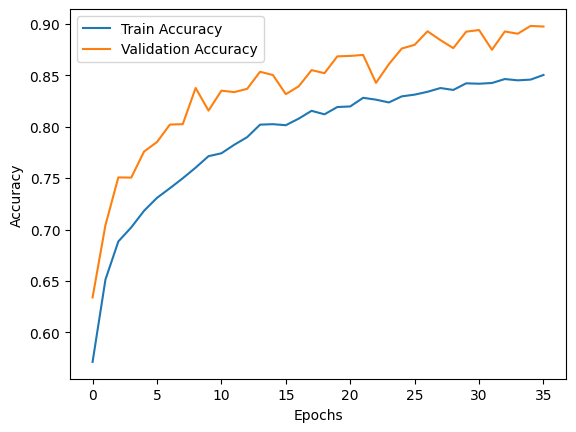

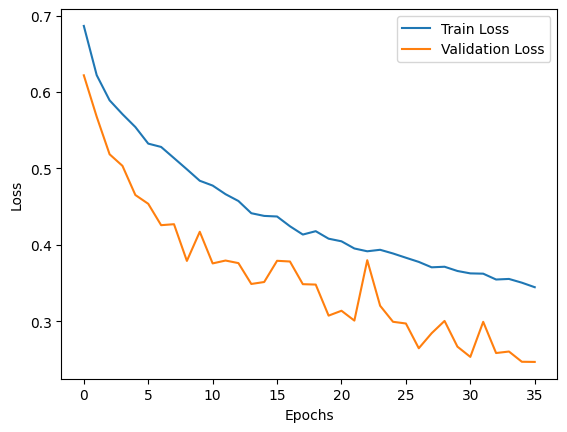

In [14]:
# Evaluasi model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Plot accuracy dan loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Konversi Model

In [15]:
# Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model yang dikonversi
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp344wdm27'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135535360176928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360175344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360174464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360177984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360179040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360314704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360314352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360316816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360312592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360318752: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Inference (Optional)

In [16]:
# Fungsi untuk melakukan inference pada gambar
def predict_image(image_path, model):
    img = load_img(image_path, target_size=(150, 150))  # Memuat gambar dan mengubah ukurannya
    img_array = img_to_array(img) / 255.0  # Mengubah gambar menjadi array dan menormalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan batch dimension

    prediction = model.predict(img_array)

    # Prediksi berdasarkan nilai keluaran dari model
    if prediction[0] > 0.5:
        print(f"Prediction: Dog ({prediction[0][0] * 100:.2f}%)")
    else:
        print(f"Prediction: Cat ({(1 - prediction[0][0]) * 100:.2f}%)")


In [17]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 109.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [19]:
# Menyimpan model ke dalam format SavedModel
model.export('/content/saved_model')

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135535360176928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360175344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360174464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360177984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360179040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360314704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360314352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360316816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360312592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135535360318752: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [20]:
# Menyimpan model ke dalam format .keras (native Keras format)
model.save('/content/model.keras')

In [21]:
# Menyimpan model ke dalam format HDF5 (.h5)
model.save('/content/model.h5')

In [22]:
import tensorflow as tf

# Konversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

# Simpan model .tflite ke Google Colab
with open('/content/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Download model .tflite ke lokal
from google.colab import files
files.download('/content/model.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
pip freeze requirements.txt


absl-py==1.4.0
accelerate==0.34.2
aiohappyeyeballs==2.4.0
aiohttp==3.10.5
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.15
albumentations==1.4.15
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.19.0
asn1crypto==1.5.1
astropy==6.1.3
astropy-iers-data==0.2024.9.16.0.32.21
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.17.0
bigquery-magics==0.2.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
bqplot==0.12.43
branca==0.7.2
build==1.2.2
CacheControl==0.14.0
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.19.0
cloudpickle==2.2.1
cmake==3.30.3
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1